# Welcome to our CIS 519 final project! 
## In this notebook, our goal is to apply ML/DL models to the dataset and extract the most supportable phrase or word of a given text according to an associated sentiment. Let's begin! :)

# Setup


## **import libraries**

In [ ]:
## Data preprocessing part
import pandas as pd
import re
import string
import numpy as np
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS

##**Glove embeddings**

In [ ]:
!wget -nc https://nlp.stanford.edu/data/glove.840B.300d.zip
!unzip glove.840B.300d.zip
!ls -lat

--2022-04-25 04:07:09--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2022-04-25 04:07:09--  http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/zip]
Saving to: ‘glove.840B.300d.zip’

glove.840B.300d.zip 100%[===================>]   2.03G  5.06MB/s    in 6m 51s  

2022-04-25 04:14:00 (5.05 MB/s) - ‘glove.840B.300d.zip’ saved [2176768927/2176768927]

Archive:  glove.840B.300d.zip
  inflating: glove.840B.300d.txt     
total 

In [ ]:
glove_file = "glove.840B.300d.txt"

# **1. Exploratory Data Analysis**

## **1.1 Data overview**

First lets All data is stored in train.csv file with 27481 rows.

The source of the data is from kaggle comepetitions: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv 

**Columns**

- **textID** - unique ID for each piece of the text
- **text** - the text of the tweet
- **sentiment** - the general sentiment of the tweet
- **selected_text** - the text that supports the tweet's sentiment


In [ ]:
data = pd.read_csv('/content/train.csv')
data.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [ ]:
print("Shape of data:", data.shape)

Shape of data: (27481, 4)


There is only 1 row that contains the null value. So, we will drop it later in data preprocessing section.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


Look in to the data, there are three possible sentiment types (neutral, positive and negative) for a given text. If the sentiment of a text is neutral, then the selected_text should be the entire text. If the sentiment of a text is either positive or negative, the selected_text should be a word or a phrase that is part of the text that encapsulate the labeled sentiment. For example,

In [ ]:
data[data['sentiment'] == 'neutral'].head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral
7,50e14c0bb8,Soooo high,Soooo high,neutral
8,e050245fbd,Both of you,Both of you,neutral
10,2339a9b08b,"as much as i love to be hopeful, i reckon the...","as much as i love to be hopeful, i reckon the ...",neutral


In [ ]:
data[data['sentiment'] == 'positive'].head()

,textID,text,selected_text,sentiment
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive
11,16fab9f95b,I really really like the song Love Story by Ta...,like,positive
21,e48b0b8a23,Playing Ghost Online is really interesting. Th...,interesting.,positive
25,e00c6ef376,"the free fillin` app on my ipod is fun, im add...","the free fillin` app on my ipod is fun, im add...",positive


In [ ]:
data[data['sentiment'] == 'negative'].head()

,textID,text,selected_text,sentiment
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
12,74a76f6e0a,My Sharpie is running DANGERously low on ink,DANGERously,negative


## **1.2 Dataset distribution visualization**

Let's visualize the distribution of the dataset. 

Overall, the dataset is relatively average distributed. There are 27481 texts in total. Among them, 11118 tweets (around 40%) are labeled neutral, 8582 (aroud 31%) are labeled positive and 7781 (around 28%) are labeled negative.

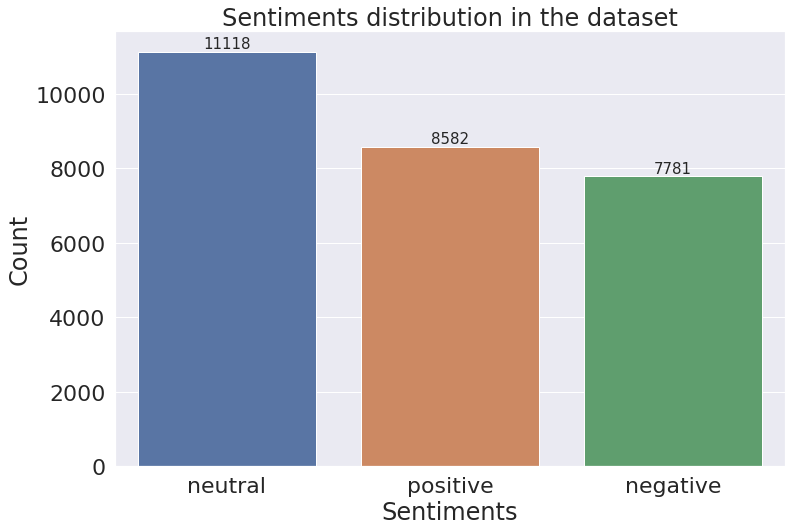

In [ ]:
sentiments = {}
sentiments['neutral'] = data[data['sentiment'] == 'neutral'].shape[0]
sentiments['positive'] = data[data['sentiment'] == 'positive'].shape[0]
sentiments['negative'] = data[data['sentiment'] == 'negative'].shape[0]

plt.figure(figsize=(12, 8))
sns.set(font_scale=2)
ax = sns.barplot(x=list(sentiments.keys()), y=list(sentiments.values()))
for bar in ax.patches:
  ax.annotate(format(bar.get_height(),'.0f'),
              (bar.get_x() + bar.get_width() / 2,
              bar.get_height()), ha='center', va='center',
              size=15, xytext=(0, 8),
              textcoords='offset points')
ax.set_xlabel("Sentiments")
ax.set_ylabel("Count")
ax.set_title("Sentiments distribution in the dataset")
plt.show()

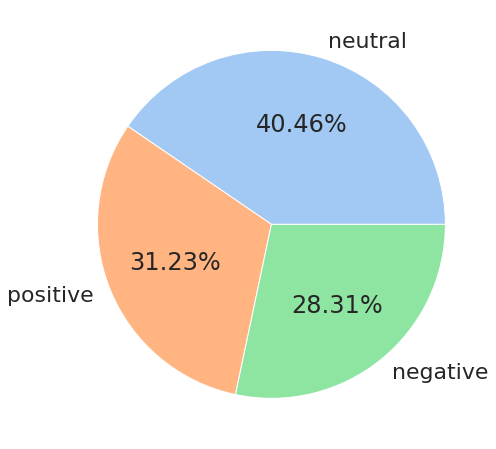

In [ ]:
plt.figure(figsize=(12, 8))
colors = sns.color_palette('pastel')[0:5]
plt.pie(list(sentiments.values()), labels = list(sentiments.keys()), colors = colors, autopct='%.2f%%')
plt.show()

# **2. Data preprocessing**

**For machine learning or deep learning, data wrangling is very essential to improve the effectiveness and avoid any unnecessary errors. Since the dataset we get is tweets from the web, which vary from person to person, we need to clean the data. In this section, we are going to perform data preprocessing on the data, such as unifying lowercase, removing hyperlinks, etc.**

In [ ]:
#@title Helper functions
## Data preprocessing part
def remove_hyperlinks(text):
  hyperlinkfree=re.sub('https?://\S+|www\.\S+', '', text)
  return hyperlinkfree

def remove(text):
  text=re.sub('\S*\d\S*',' ',text) #Removing Numbers
  text=re.sub('<.*?>+',' ',text)   #Removing Angular Brackets
  text=re.sub('\[.*?\]',' ',text)  #Removing Square Brackets
  text=re.sub('\n',' ',text)       #Removing '\n' character 
  text=re.sub('\*+','ABUSE',text) #Replacing **** by ABUSE word
  return text

def remove_punctuation(text):
  punctuationfree="".join([i for i in text if i not in string.punctuation])
  return punctuationfree

def wrong_words(text,selected):
  words=[]
  text = str(text)
  selected= str(selected)
  text=text.split()
  selected=selected.split()
  for i in selected:
    if i not in text:
      words.append(i)
  if len(words)>0:
    return " ".join(words)
  else:
    return '++++'

def remove_text(x):
  selected=x[0]
  spelling=x[1]
  selected=selected.split()
  selected.remove(spelling) 
  return " ".join(selected)

def matching_55(x):
  text=x[0]
  selected=x[1]
  spelling=x[2]
  text=text.split()
  selected=selected.split()
  spelling=spelling.split()
  for s in spelling:
    for t in text:
      if s in selected:
        if(fuzz.ratio(t,s)>55): 
          index=selected.index(s)
          selected[index]=t
  return " ".join(selected) 

def matching_35(x):
  text=x[0]
  selected=x[1]
  spelling=x[2]
  text=text.split()
  selected=selected.split()
  spelling=spelling.split()
  for s in spelling:
    for t in text:
      if s in selected:
        if(fuzz.ratio(t,s)>35):
          index=selected.index(s)
          selected[index]=t
  return " ".join(selected)

def start_index(x):
  text=x[0]
  selected=x[1]
  text=text.split()
  selected=selected.split()
  word=selected[0]
  index=text.index(word)
  return index

def end_index(x):
  text=x[0]
  selected=x[1]
  start_index=x[2] 
  text=text.split()
  selected= selected.split()
  word=selected[-1]
  try:
    index=text.index(word,start_index)
  except:
    index=text.index(word)
  return index

def get_text(x):
  pred=[]
  text=x[0]
  index=x[1]
  text=text.split()
  l=len(text)
  # nothing output = output all
  if len(index) == 0:
    pred = text
  for i in index:
    if i < l:
      pred.append(text[i])
  return pred

def jaccard(str1,str2): 
  a=set(str1.lower().split()) 
  b=set(str2.lower().split())
  c=a.intersection(b)

  return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


Here, we are unifying the lower case.

In [ ]:
data['text']= data['text'].apply(lambda x: x.lower() if type(x) == str else x)
data['selected_text']= data['selected_text'].apply(lambda x: x.lower() if type(x) == str else x)
data.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"sons of ****, why couldn`t they put them on t...","sons of ****,",negative


Here, we are removing the hyperlinks. 

For example, after visualization, we found that the text with index 5 contains hyperlink.

In [ ]:
data.iloc[5]

textID                                                  28b57f3990
text             http://www.dothebouncy.com/smf - some shameles...
selected_text    http://www.dothebouncy.com/smf - some shameles...
sentiment                                                  neutral
Name: 5, dtype: object

In [ ]:
data['text']=data['text'].apply(lambda x:remove_hyperlinks(x) if type(x) == str else x)
data['selected_text']=data['selected_text'].apply(lambda x:remove_hyperlinks(x) if type(x) == str else x)

After processing, the hyperlink has been removed.

In [ ]:
data.iloc[5]

textID                                                  28b57f3990
text              - some shameless plugging for the best ranger...
selected_text     - some shameless plugging for the best ranger...
sentiment                                                  neutral
Name: 5, dtype: object

Here, we are removing any numbers, brackets and special character and replacing **** with 'ABUSE' in text and selected_text.

In [ ]:
data['text']=data['text'].apply(lambda x:remove(x) if type(x) == str else x)
data['selected_text']=data['selected_text'].apply(lambda x:remove(x) if type(x) == str else x)
data.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"sons of ABUSE, why couldn`t they put them on ...","sons of ABUSE,",negative


Here, we are removing any punctuation in text and selected_text.

In [ ]:
data['text']=data['text'].apply(lambda x:remove_punctuation(x) if type(x) == str else x)
data['selected_text']=data['selected_text'].apply(lambda x:remove_punctuation(x) if type(x) == str else x)
data.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative
2,088c60f138,my boss is bullying me,bullying me,negative
3,9642c003ef,what interview leave me alone,leave me alone,negative
4,358bd9e861,sons of ABUSE why couldnt they put them on th...,sons of ABUSE,negative


After above preprocessing, there may be some text or selected text contains the blank space only. We need also to take this into consideration and drop these rows. For example,

In [ ]:
data[data["text"]==' ']

,textID,text,selected_text,sentiment
1319,bc84f21e3b,,shoesshoesshoesyayyayyayloli,positive
24926,0872ed0f00,,,neutral


In [ ]:
data[data["selected_text"]==' ']

,textID,text,selected_text,sentiment
9533,c6149b7abf,its castiel,,positive
10997,6d85945e2c,hussein i have to wake up earlier than i thou...,,negative
13728,c7b78c1b26,btw and i ordered some of yer merch yester...,,positive
24348,a21d9c38a8,ill keep working on her lol good idea,,positive
25455,b6bf74a5c8,europe sounds will finish my exam on teus a...,,positive
25637,370880f242,its realy my book is on the side im not stu...,,negative


In [ ]:
data.drop(data[data["text"]==' '].index,inplace=True)
data.drop(data[data["selected_text"]==' '].index,inplace=True)

By visualization, we found that there are some selected_text that contain wrong spelling word. So, in the next few steps, we are detecting the words with wrong spelling and correcting them accordingly. For example,

In [ ]:
data.iloc[27467].text, data.iloc[27467].selected_text

(' wish we could come see u on denver  husband lost his job and cant afford it',
 'd lost')

In [ ]:
data['spelling']=data.apply(lambda x: wrong_words(x.text,x.selected_text),axis=1)
data

,textID,text,selected_text,sentiment,spelling
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral,++++
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative,++++
2,088c60f138,my boss is bullying me,bullying me,negative,++++
3,9642c003ef,what interview leave me alone,leave me alone,negative,++++
4,358bd9e861,sons of ABUSE why couldnt they put them on th...,sons of ABUSE,negative,++++
...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on denver husband l...,d lost,negative,d
27477,4f4c4fc327,ive wondered about rake to the client has ma...,dont force,negative,++++
27478,f67aae2310,yay good for both of you enjoy the break you...,yay good for both of you,positive,++++
27479,ed167662a5,but it was worth it ABUSE,but it was worth it ABUSE,positive,++++


In [ ]:
data['selected_text']=data[['selected_text','spelling']].apply(lambda x: remove_text(x) if len(x['spelling'])==1  else x['selected_text'],axis=1)
data['spelling']=data.apply(lambda x: wrong_words(x.text,x.selected_text),axis=1)
data

,textID,text,selected_text,sentiment,spelling
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral,++++
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative,++++
2,088c60f138,my boss is bullying me,bullying me,negative,++++
3,9642c003ef,what interview leave me alone,leave me alone,negative,++++
4,358bd9e861,sons of ABUSE why couldnt they put them on th...,sons of ABUSE,negative,++++
...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on denver husband l...,lost,negative,++++
27477,4f4c4fc327,ive wondered about rake to the client has ma...,dont force,negative,++++
27478,f67aae2310,yay good for both of you enjoy the break you...,yay good for both of you,positive,++++
27479,ed167662a5,but it was worth it ABUSE,but it was worth it ABUSE,positive,++++


In [ ]:
data[data['spelling']!='++++']

,textID,text,selected_text,sentiment,spelling
18,af3fed7fc3,is back home now gonna miss every one,onna,negative,onna
27,bdc32ea43c,on the way to malaysiano internet access to twit,no internet,negative,no
32,1c31703aef,if it is any consolation i got my bmi tested ...,well so much for being unhappy for about minute,negative,minute
39,2863f435bd,a little happy for the wine jeje ok itsm my fr...,a little happy fo,positive,fo
48,3d9d4b0b55,i donbt like to peel prawns i also dont like g...,dont like go,negative,go
...,...,...,...,...,...
27376,13fbc75291,going to church in the morninghappy mommas day...,happy,positive,happy
27386,e149ebd3a1,would one of the vwllers want to add this ev...,ch appreciat,positive,ch appreciat
27401,261e064dd4,oh silence verona i am wanting to go jaja ...,ja enjoyyitverymu,positive,ja enjoyyitverymu
27456,d32efe060f,i wanna leave work already not feelin it,wanna leave work al,negative,al


From above visualization, there are still some wrong spelling words in categorial "selected_text". Next, we gonna correct them according to different situation. The first one is for selected_text with neutral sentiment. In this case, we want the selected_text to output the entire given text.

In [ ]:
data['selected_text']=data.apply(lambda x: x['text'] if ( (x['spelling']!='++++') & (x['sentiment']=='neutral') ) else x['selected_text'],axis=1)
data['spelling']=data.apply(lambda x: wrong_words(x.text,x.selected_text),axis=1)
data[(data['spelling']!='++++') & (data['sentiment']=='neutral')].head()

,textID,text,selected_text,sentiment,spelling


For other cases, if there are still wrong spelling words in the selected text, then it means the wrong spelling words has a similiar match in the text. In this case, we are trying to match the words with the one using the FuzzyWuzzy string matching method.

In [ ]:
data['selected_text']=data[['text','selected_text','spelling']].apply(lambda x: matching_55(x) if x['spelling']!='++++'  else x['selected_text'],axis=1)
data['spelling']=data.apply(lambda x: wrong_words(x.text,x.selected_text),axis=1)
data[data['spelling']!='++++']

,textID,text,selected_text,sentiment,spelling
27,bdc32ea43c,on the way to malaysiano internet access to twit,no internet,negative,no
223,242d92151a,walking to class i hate not having a bikeespec...,i hate not having a bike,negative,bike
349,322b61740c,degrees gross skies and thunderstormsperfect...,perfect match,positive,perfect
362,b94aaf845e,please review sunehre ad placement,please re,positive,re
569,03f9f6f798,i dont think ive ever been so tierd in my life...,i dont think ive ever been so tierd in my lifeu,negative,lifeu
...,...,...,...,...,...
26883,ee30bf8953,im yours jason mrazlooking for an electric gu...,yay,positive,yay
27209,30a1e8c2b4,guys i know my ability to read time telli...,es failed,negative,es
27302,90c8aa60db,have i ever told you i absolutly hate writing ...,hate wr,negative,wr
27362,7b82d63ee4,just found out i wont be tweeting from my phon...,c sorry,negative,c


In [ ]:
data['selected_text']=data[['selected_text','spelling']].apply(lambda x: remove_text(x) if len(x['spelling'])==1  else x['selected_text'],axis=1)
data['spelling']=data.apply(lambda x: wrong_words(x.text,x.selected_text),axis=1)
data[data['spelling']!='++++']

,textID,text,selected_text,sentiment,spelling
27,bdc32ea43c,on the way to malaysiano internet access to twit,no internet,negative,no
223,242d92151a,walking to class i hate not having a bikeespec...,i hate not having a bike,negative,bike
349,322b61740c,degrees gross skies and thunderstormsperfect...,perfect match,positive,perfect
362,b94aaf845e,please review sunehre ad placement,please re,positive,re
569,03f9f6f798,i dont think ive ever been so tierd in my life...,i dont think ive ever been so tierd in my lifeu,negative,lifeu
...,...,...,...,...,...
26248,7d4f718542,gates am also guttedthe end is nigh x,the end is nigh,negative,the
26883,ee30bf8953,im yours jason mrazlooking for an electric gu...,yay,positive,yay
27209,30a1e8c2b4,guys i know my ability to read time telli...,es failed,negative,es
27302,90c8aa60db,have i ever told you i absolutly hate writing ...,hate wr,negative,wr


In [ ]:
data['selected_text']=data[['text','selected_text','spelling']].apply(lambda x: matching_35(x) if x['spelling']!='++++'  else x['selected_text'],axis=1)
data['spelling']=data.apply(lambda x: wrong_words(x.text,x.selected_text),axis=1)
data[data['spelling']!='++++']

,textID,text,selected_text,sentiment,spelling
1588,a7f72a928a,woooooooooo are you coming to nottingham at...,to lovelovelove,positive,lovelovelove
2398,983dfecd25,gonna do laundrynever did laundry a hotel bef...,did miss you r,negative,r
6113,2cb67e64b4,these dogs are going to die if somebody doe...,aam these dogs are going to die if somebody do...,negative,aam
7410,3463ecdfd6,imintheroom imwatchingthehannahmoviewithmomshe...,great,positive,great
9817,3358792fc9,following and followers nice,not nice,negative,not
10521,f29edbc282,dora the explorer greetings to your niece,enjoy,positive,enjoy
13637,d83fd6c942,tweeets fgs tweekdeckkk hates me cryyyy,kk hates me cryyyy,negative,kk
14839,b19376c3bd,just got back fromahem boring but had to eat...,was boring but had to eat nonetheless,negative,was
16201,e78c1ad3f5,off to work off at,lammmeeee,negative,lammmeeee
25293,2fdbe40c03,grreverytime he gets a new girlfriendim at the...,im at the bottom of the totem pole,negative,im


After string matching, there are still some wrong spelling words in selected_text. In this case, we should manually correct them based on the given text. 

In [ ]:
# negative
data.loc[2398].selected_text='did miss you'
data.loc[6113].selected_text='these dogs are going to die if somebody doesnt save them'
data.loc[9817].text='following and followers not nice'
data.loc[13637].selected_text='hates me cryyyy'
data.loc[14839].selected_text='boring but had to eat nonetheless'
data.loc[16201].selected_text='off to work'
data.loc[25293].selected_text='at the bottom of the totem pole'

# positive
data.loc[1588].selected_text='woooooooooo'
data.loc[10521].selected_text='greetings'
data.loc[7410].text='im in the room im watching the hannah movie with mom she said this film very great'

data['spelling']=data.apply(lambda x: wrong_words(x.text,x.selected_text),axis=1)

data[data['spelling'].apply(lambda x: len(x))==1]
data[data['spelling']!='++++']

,textID,text,selected_text,sentiment,spelling


In [ ]:
data.reset_index(inplace=True)
data.drop(['index'],inplace=True,axis=1)

data.drop(8727,inplace=True)
data.drop(25996,inplace=True)

data.reset_index(inplace=True)
data.drop(['index'],inplace=True,axis=1)

Since the selected_text is one phrase or the entire text, we can represent the selected_text numerically by figuring out its postion (start_index and end_index) in the given text.

In [ ]:
data['start_index']=data[['text','selected_text']].apply(lambda x: start_index(x),axis=1)
data['end_index']=data[['text','selected_text','start_index']].apply(lambda x: end_index(x),axis=1)

data= data[data.start_index <= data.end_index]

data.reset_index(inplace=True)
data.drop(['index'],inplace=True,axis=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
data

,textID,text,selected_text,sentiment,spelling,start_index,end_index
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral,++++,0,6
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative,++++,0,1
2,088c60f138,my boss is bullying me,bullying me,negative,++++,3,4
3,9642c003ef,what interview leave me alone,leave me alone,negative,++++,2,4
4,358bd9e861,sons of ABUSE why couldnt they put them on th...,sons of ABUSE,negative,++++,0,2
...,...,...,...,...,...,...,...
27376,4eac33d1c0,wish we could come see u on denver husband l...,lost,negative,++++,9,9
27377,4f4c4fc327,ive wondered about rake to the client has ma...,dont force,negative,++++,13,14
27378,f67aae2310,yay good for both of you enjoy the break you...,yay good for both of you,positive,++++,0,5
27379,ed167662a5,but it was worth it ABUSE,but it was worth it ABUSE,positive,++++,0,5


In [ ]:
print("Data shape after preprocessing is:", data.shape)

Data shape after preprocessing is: (27381, 7)


Let's do more exploratory data analysis!

In [ ]:
eda = data.iloc[:]
eda['text_length']=data['text'].astype(str).apply(len)
eda['text_word_count']= data['text'].apply(lambda x: len(str(x).split()))
eda['selected_text_word_count']= data['selected_text'].apply(lambda x: len(str(x).split()))
eda.head()

,textID,text,selected_text,sentiment,spelling,start_index,end_index,text_length,text_word_count,selected_text_word_count
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral,++++,0,6,34,7,7
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative,++++,0,1,43,10,2
2,088c60f138,my boss is bullying me,bullying me,negative,++++,3,4,22,5,2
3,9642c003ef,what interview leave me alone,leave me alone,negative,++++,2,4,30,5,3
4,358bd9e861,sons of ABUSE why couldnt they put them on th...,sons of ABUSE,negative,++++,0,2,74,14,3


From the below figures, we see that the distribution of neutral, positive and negative text_length vary from 0 to 140. Most text lengths are between 20 - 40.

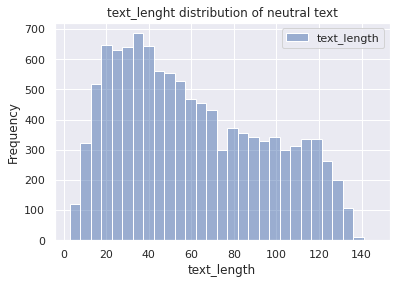

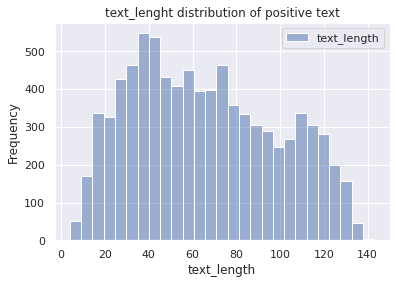

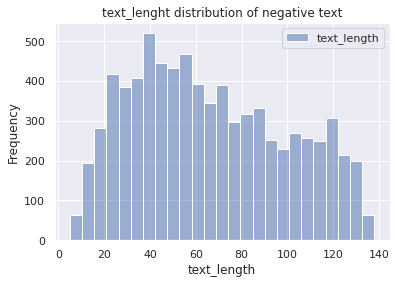

In [ ]:
neutral = eda[eda['sentiment'] == 'neutral'][['text_length']]
plt.figure()
ax = sns.histplot(neutral)
ax.set_xlabel("text_length")
ax.set_ylabel("Frequency")
ax.set_title("text_lenght distribution of neutral text")
plt.show()

positive = eda[eda['sentiment'] == 'positive'][['text_length']]
plt.figure()
ax = sns.histplot(positive)
ax.set_xlabel("text_length")
ax.set_ylabel("Frequency")
ax.set_title("text_lenght distribution of positive text")
plt.show()

negative = eda[eda['sentiment'] == 'negative'][['text_length']]
plt.figure()
ax = sns.histplot(negative)
ax.set_xlabel("text_length")
ax.set_ylabel("Frequency")
ax.set_title("text_lenght distribution of negative text")
plt.show()

The distribution of the word counts for three sentiments are similar varies from 0 - 30. For neutral and negative tweets, most text word counts are between 5 - 10. However, for positive tweets, the most text word counts are around 16.

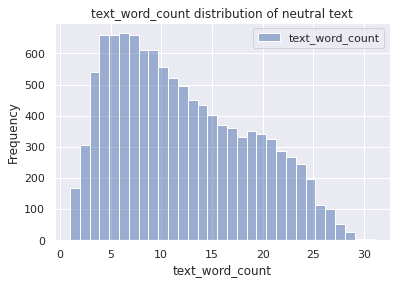

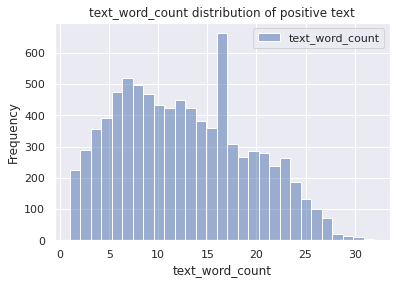

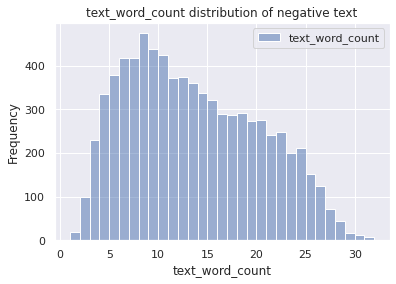

In [ ]:
neutral = eda[eda['sentiment'] == 'neutral'][['text_word_count']]
plt.figure()
ax = sns.histplot(neutral)
ax.set_xlabel("text_word_count")
ax.set_ylabel("Frequency")
ax.set_title("text_word_count distribution of neutral text")
plt.show()

positive = eda[eda['sentiment'] == 'positive'][['text_word_count']]
plt.figure()
ax = sns.histplot(positive)
ax.set_xlabel("text_word_count")
ax.set_ylabel("Frequency")
ax.set_title("text_word_count distribution of positive text")
plt.show()

negative = eda[eda['sentiment'] == 'negative'][['text_word_count']]
plt.figure()
ax = sns.histplot(negative)
ax.set_xlabel("text_word_count")
ax.set_ylabel("Frequency")
ax.set_title("text_word_count distribution of negative text")
plt.show()

We also plot the figure of selected_text word counts distribution for each sentiment. The results are shown as below:

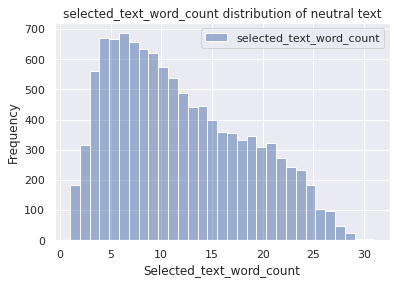

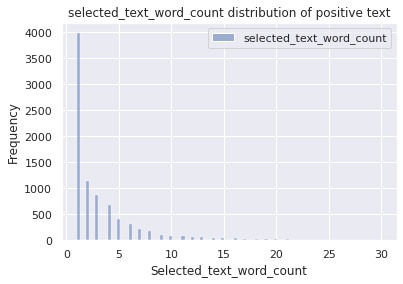

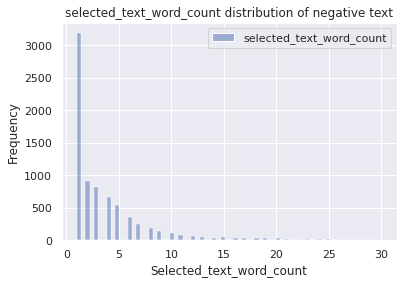

In [ ]:
neutral = eda[eda['sentiment'] == 'neutral'][['selected_text_word_count']]
plt.figure()
ax = sns.histplot(neutral)
ax.set_xlabel("Selected_text_word_count")
ax.set_ylabel("Frequency")
ax.set_title("selected_text_word_count distribution of neutral text")
plt.show()

positive = eda[eda['sentiment'] == 'positive'][['selected_text_word_count']]
plt.figure()
ax = sns.histplot(positive)
ax.set_xlabel("Selected_text_word_count")
ax.set_ylabel("Frequency")
ax.set_title("selected_text_word_count distribution of positive text")
plt.show()

negative = eda[eda['sentiment'] == 'negative'][['selected_text_word_count']]
plt.figure()
ax = sns.histplot(negative)
ax.set_xlabel("Selected_text_word_count")
ax.set_ylabel("Frequency")
ax.set_title("selected_text_word_count distribution of negative text")
plt.show()

Lastly, let's us visualize the datasets with the worldclouds.

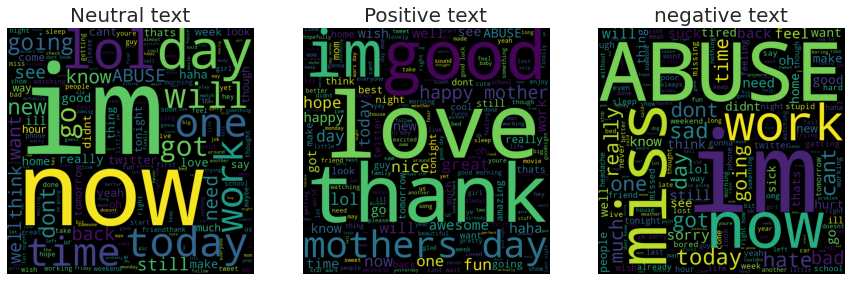

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(15,10))
stopwords = set(STOPWORDS)
wordcloud1 = WordCloud(width = 800, height = 800,
                stopwords = stopwords,
                min_font_size = 10).generate(" ".join(data[data['sentiment']=='neutral']['text']))
                      
ax[0].imshow(wordcloud1)
ax[0].axis("off")
ax[0].set_title('Neutral text',fontsize=20)

wordcloud2 = WordCloud(width = 800, height = 800,
                stopwords = stopwords,
                min_font_size = 10).generate(" ".join(data[data['sentiment']=='positive']['text']))
                     
ax[1].imshow(wordcloud2)
ax[1].axis("off")
ax[1].set_title('Positive text',fontsize=20)

wordcloud3 = WordCloud(width = 800, height = 800,
                stopwords = stopwords,
                min_font_size = 10).generate(" ".join(data[data['sentiment']=='negative']['text']))
                     
ax[2].imshow(wordcloud3)
ax[2].axis("off")
ax[2].set_title('negative text',fontsize=20)

plt.show()

# **3.Sentiment Analysis using LSTM & Bi-LSTM**





###**import** 

In [ ]:
## Training part
from tqdm import tqdm
import tensorflow as tf
!pip install --upgrade tensorflow
from sklearn.model_selection import train_test_split

     |████████████████████████████████| 462 kB 13.8 MB/s 


### **Splitting dataset & Tokenization**

In [ ]:
def one_hot_coding(raw_data, max_len_text):
    # Get X, y for training
    X=raw_data[['textID','text','selected_text','sentiment']]

    y=np.zeros((raw_data.shape[0],max_len_text+1))
    for i in range(raw_data.shape[0]):
      start=raw_data['start_index'][i]
      end=raw_data['end_index'][i]
      y[i][start:end+1]=1

    return X, y

In [ ]:
# splitting data into train &test dataset
train = data.sample(frac=0.85, random_state=200)
test = data.merge(train, how='left', indicator=True)
test = test[test['_merge'] == 'left_only']

train.reset_index(inplace = True)
test.reset_index(inplace = True)

text_split=data['text'].apply(lambda x: len(str(x).split())).tolist()
max_len_text = max(text_split)

# X_train.shape (23274, 4), X_test.shape (4107, 4)
# y_train.shape (23274, 33), y_test.shape (4107, 33)
X_train, y_train = one_hot_coding(train, max_len_text)
X_test, y_test = one_hot_coding(test, max_len_text)
# X_test = X_test[['textID','text','sentiment']]

# Split into training data & validation data
## X_train shape  (21877, 4)  , X_valid shape  (1397, 4)
## y_train shape  (21877, 33) ,  y_valid shape  (1397, 33)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.06, random_state=42)

In [ ]:
# Add dims (y shape)
y_train=np.expand_dims(y_train,-1)
y_valid=np.expand_dims(y_valid,-1)
# transfer text & sentiment into list of strings
train_text=X_train['text'].values
valid_text=X_valid['text'].values
train_sentiment=X_train['sentiment'].values
valid_sentiment=X_valid['sentiment'].values

In [ ]:
# Keras tokenizer( text)
token1= tf.keras.preprocessing.text.Tokenizer(num_words=None)

token1.fit_on_texts(list(train_text))
train_text=token1.texts_to_sequences(train_text)
valid_text=token1.texts_to_sequences(valid_text)

# Keras tokenizer( sentiment)
token2= tf.keras.preprocessing.text.Tokenizer(num_words=None)

token2.fit_on_texts(list(train_sentiment))
train_sentiment=token2.texts_to_sequences(train_sentiment)
valid_sentiment=token2.texts_to_sequences(valid_sentiment)

# Pads each sequence to the same length
max_len_text=32
train_text= tf.keras.preprocessing.sequence.pad_sequences(train_text,maxlen=max_len_text,padding='post')
valid_text= tf.keras.preprocessing.sequence.pad_sequences(valid_text,maxlen=max_len_text,padding='post')
max_len_sentiment=1
train_sentiment= tf.keras.preprocessing.sequence.pad_sequences(train_sentiment,maxlen=max_len_sentiment,padding='post')
valid_sentiment= tf.keras.preprocessing.sequence.pad_sequences(valid_sentiment,maxlen=max_len_sentiment,padding='post')

word_index_text=token1.word_index
word_index_sentiment=token2.word_index

In [ ]:
# test data
test_text = test['text'].values
test_sentiment = test['sentiment'].values

test_text=token1.texts_to_sequences(test_text)
test_text=tf.keras.preprocessing.sequence.pad_sequences(test_text,maxlen=max_len_text,padding='post')

test_sentiment=token2.texts_to_sequences(test_sentiment)
test_sentiment=tf.keras.preprocessing.sequence.pad_sequences(test_sentiment,maxlen=max_len_sentiment,padding='post')

In [ ]:
test

,index,textID,text,selected_text,sentiment,spelling,start_index,end_index,_merge
0,3,9642c003ef,what interview leave me alone,leave me alone,negative,++++,2,4,left_only
1,5,28b57f3990,some shameless plugging for the best rangers...,some shameless plugging for the best rangers...,neutral,++++,0,9,left_only
2,17,919fa93391,ive been sick for the past few days and thus ...,sick,negative,++++,2,2,left_only
3,18,af3fed7fc3,is back home now gonna miss every one,gonna,negative,++++,4,4,left_only
4,23,9ce5570064,gotta restart my computer i thought was sup...,gotta restart my computer i thought was sup...,neutral,++++,0,15,left_only
...,...,...,...,...,...,...,...,...,...
4102,27313,4887a44500,so trueand so poetic beautiful,beautiful,positive,++++,4,4,left_only
4103,27325,ef389b4d71,happy mothers day to all mums in america,happy,positive,++++,0,0,left_only
4104,27335,744ae79733,back from cycling miles on virtually traffic...,great start,positive,++++,13,14,left_only
4105,27362,3f9912ec7a,just back from bingo wfamily i won over fun...,fun,positive,++++,8,8,left_only


### **Embeddings**

In [ ]:
# load the GloVe vectors in a dictionary:
embeddings_index = {}
with open('/content/glove.840B.300d.txt') as f:
  for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
print('Found %s word vectors.' % len(embeddings_index))

2196017it [04:04, 8997.72it/s]

Found 2196016 word vectors.


In [ ]:
# Use pre-trained word embedding 
# create  an embedding matrix for text
embedding_matrix_text=np.zeros((len(word_index_text) + 1, 300))
for word, i in word_index_text.items():
    embedding_vector=embeddings_index.get(word)
    if embedding_vector is not None: # words not found in embedding index will be all-zeros.
        embedding_matrix_text[i]=embedding_vector
 
# create  an embedding matrix for sentiment
embedding_matrix_sentiment=np.zeros((len(word_index_sentiment) + 1, 300))
for word, i in word_index_sentiment.items():
    embedding_vector=embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_sentiment[i]=embedding_vector

## **3.1 LSTM architecture**

In [ ]:
# LSTM model part
from tensorflow.keras.layers import LSTM
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import jaccard_score
from tensorflow.keras import optimizers
from keras.regularizers import l2


In [ ]:
text_input=layers.Input(shape=(max_len_text,), name='text input')
text_embedding = layers.Embedding(
    len(word_index_text)+1,
    300,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix_text),
    mask_zero=True,
    trainable=False,
    input_length=max_len_text, name = 'text_embedding')(text_input)
sentiment_input=layers.Input(shape=(max_len_sentiment,), name = 'sentiment input')
sentiment_embedding = layers.Embedding(
    len(word_index_sentiment)+1,
    300,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix_sentiment),
    mask_zero=True,
    trainable=False,
    input_length=max_len_sentiment, name = 'sentiment_embedding')(sentiment_input)
con=layers.Concatenate(axis=1, name = 'concatenate')([text_embedding,sentiment_embedding])
lstm=LSTM(32,return_sequences=True, kernel_regularizer=l2(0.01), name = 'LSTM_layer')(con) #lstm

d = layers.Dense(16,activation="relu", kernel_regularizer=l2(0.01), name = 'Dense_layer1')(lstm)
d = layers.Dropout(0.5, name = 'Dropout_layer')(d)
d = layers.BatchNormalization(name = 'Batchnormalization_layer')(d)
d = layers.Dense(4,activation="relu", kernel_regularizer=l2(0.01), name = 'Dense_layer2')(d)
output=layers.Dense(1,activation='sigmoid', name = 'output_layer')(d)

model1=keras.Model(inputs=[text_input,sentiment_input],outputs=[output])

In [ ]:
loss = keras.losses.BinaryCrossentropy(from_logits=False)
optim = keras.optimizers.Adam(lr=0.001)
metrics = ["accuracy"]

model1.compile(loss=loss, optimizer=optim, metrics=metrics)

history=model1.fit([train_text,train_sentiment],y_train,epochs=30,batch_size=128,\
                  validation_data=([valid_text,valid_sentiment],y_valid),verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
171/171 [==============================] - 12s 45ms/step - loss: 0.7775 - accuracy: 0.5588 - val_loss: 0.3261 - val_accuracy: 0.5979
Epoch 2/30
171/171 [==============================] - 6s 38ms/step - loss: 0.3001 - accuracy: 0.5915 - val_loss: 0.2686 - val_accuracy: 0.6039
Epoch 3/30
171/171 [==============================] - 6s 37ms/step - loss: 0.2743 - accuracy: 0.6012 - val_loss: 0.2499 - val_accuracy: 0.6229
Epoch 4/30
171/171 [==============================] - 6s 38ms/step - loss: 0.2675 - accuracy: 0.6065 - val_loss: 0.2424 - val_accuracy: 0.6290
Epoch 5/30
171/171 [==============================] - 6s 38ms/step - loss: 0.2649 - accuracy: 0.6099 - val_loss: 0.2394 - val_accuracy: 0.6378
Epoch 6/30
171/171 [==============================] - 6s 38ms/step - loss: 0.2641 - accuracy: 0.6117 - val_loss: 0.2382 - val_accuracy: 0.6438
Epoch 7/30
171/171 [==============================] - 6s 37ms/step - loss: 0.2636 - accuracy: 0.6113 - val_loss: 0.2386 - val_accuracy: 0.633

Visualization

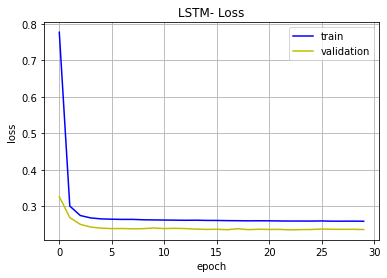

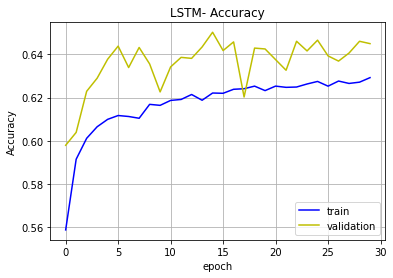

In [ ]:
plt.figure()
plt.plot(history.history['loss'], color = 'b')
plt.plot(history.history['val_loss'], color = 'y')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'])
plt.title('LSTM- Loss')
plt.grid()
plt.show()

plt.figure()
plt.plot(history.history['accuracy'], color = 'b')
plt.plot(history.history['val_accuracy'], color = 'y')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'])
plt.title('LSTM- Accuracy')
plt.grid()
plt.show()

## **3.2 Bi-LSTM architecture**

In [ ]:
text_input=layers.Input(shape=(max_len_text,))
text_embedding = layers.Embedding(
    len(word_index_text)+1,
    300,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix_text),
    mask_zero=True,trainable=False,
    input_length=max_len_text)(text_input)
sentiment_input=layers.Input(shape=(max_len_sentiment,))
sentiment_embedding = layers.Embedding(
    len(word_index_sentiment)+1,
    300,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix_sentiment),
    mask_zero=True,trainable=False,
    input_length=max_len_sentiment)(sentiment_input)
con=layers.Concatenate(axis=1)([text_embedding,sentiment_embedding])
bi_lstm=layers.Bidirectional(LSTM(16,return_sequences=True, dropout = 0.5))(con) #bi-lstm

d = layers.Dense(8,activation="relu", kernel_regularizer=l2(0.01))(bi_lstm)
d = layers.Dropout(0.5)(d)
d = layers.Dense(4,activation="relu", kernel_regularizer=l2(0.01))(d)
output=layers.Dense(1,activation='sigmoid')(d)

model2=keras.Model(inputs=[text_input,sentiment_input],outputs=[output])

In [ ]:
loss = keras.losses.BinaryCrossentropy(from_logits=False)
optim = keras.optimizers.Adam(lr=0.001)
metrics = ["accuracy"]

model2.compile(loss=loss, optimizer=optim, metrics=metrics)

history=model2.fit([train_text,train_sentiment],y_train,epochs=15,batch_size=128,\
                  validation_data=([valid_text,valid_sentiment],y_valid),verbose=1)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


171/171 [==============================] - 23s 86ms/step - loss: 0.3399 - accuracy: 0.7321 - val_loss: 0.2331 - val_accuracy: 0.8117
Epoch 2/15
171/171 [==============================] - 21s 123ms/step - loss: 0.2323 - accuracy: 0.8124 - val_loss: 0.1897 - val_accuracy: 0.8182
Epoch 3/15
171/171 [==============================] - 17s 99ms/step - loss: 0.2018 - accuracy: 0.8222 - val_loss: 0.1736 - val_accuracy: 0.8247
Epoch 4/15
171/171 [==============================] - 12s 68ms/step - loss: 0.1901 - accuracy: 0.8250 - val_loss: 0.1686 - val_accuracy: 0.8253
Epoch 5/15
171/171 [==============================] - 12s 68ms/step - loss: 0.1851 - accuracy: 0.8263 - val_loss: 0.1635 - val_accuracy: 0.8257
Epoch 6/15
171/171 [==============================] - 12s 68ms/step - loss: 0.1824 - accuracy: 0.8279 - val_loss: 0.1617 - val_accuracy: 0.8275
Epoch 7/15
171/171 [==============================] - 12s 71ms/step - loss: 0.1803 - accuracy: 0.8284 - val_loss: 0.1612 - val_accuracy: 0.8273
Ep

Visualization

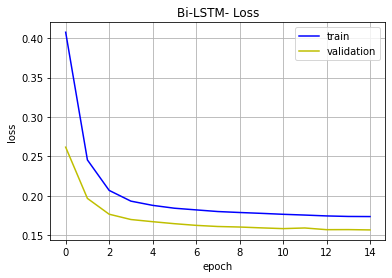

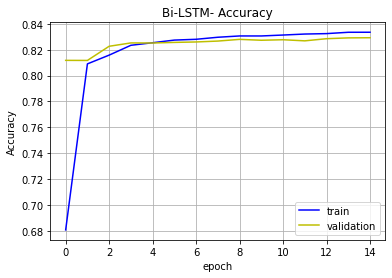

In [ ]:
plt.figure()
plt.plot(history.history['loss'], color = 'b')
plt.plot(history.history['val_loss'], color = 'y')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'])
plt.title('Bi-LSTM- Loss')
plt.grid()
plt.show()

plt.figure()
plt.plot(history.history['accuracy'], color = 'b')
plt.plot(history.history['val_accuracy'], color = 'y')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'])
plt.title('Bi-LSTM- Accuracy')
plt.grid()
plt.show()

## **3.3 Models Comparison**

In [ ]:
#@title Helper function
def jaccard(str1,str2): 
    a=set(str1.lower().split()) 
    b=set(str2.lower().split())
    c=a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

def get_index(pred):
    pred_index=[]
    for vector in pred:
      index=[]
      for i,value in enumerate(vector):
        if value == 1:
          index.append(i)
      pred_index.append(np.array(index))
    return pred_index
    
def get_text(x):
  selected_text=[]
  text=x[0]
  index=x[1]
  text=text.split()
  l=len(text)
  for i in index:
    if i < l:
      selected_text.append(text[i])
  return selected_text

LSTM

In [ ]:
pred_lstm = model1.predict([test_text,test_sentiment])
pred_lstm=np.round_(np.squeeze(pred_lstm))

test_lstm = test.copy()[['textID','text','selected_text','sentiment']]
test_lstm['prediction']=get_index(pred_lstm)
test_lstm['pred_text']=test_lstm[['text','prediction']].apply(lambda x: get_text(x),axis=1)
test_lstm['pred_text']=test_lstm['pred_text'].apply(lambda x: ' '.join(x))

test_lstm['jaccard']=test_lstm.apply(lambda x: jaccard(x.selected_text,x.pred_text),axis=1)

In [ ]:
print('LSTM Jaccard score:',np.mean(test_lstm['jaccard']))
print('LSTM jaccard score(positive sentiment):',np.mean(test_lstm[test_lstm['sentiment']=='positive']['jaccard']))
print('LSTM jaccard score(negative sentiment)',np.mean(test_lstm[test_lstm['sentiment']=='negative']['jaccard']))
print('LSTM jaccard score(neutral sentiment)',np.mean(test_lstm[test_lstm['sentiment']=='neutral']['jaccard']))

LSTM Jaccard score: 0.5483181312586016
LSTM jaccard score(positive sentiment): 0.336848343020183
LSTM jaccard score(negative sentiment) 0.3490257081741664
LSTM jaccard score(neutral sentiment) 0.8368355259562877


Bi-LSTM

In [ ]:
pred_bi_lstm = model2.predict([test_text,test_sentiment])
pred_bi_lstm=np.round_(np.squeeze(pred_bi_lstm))

test_bi_lstm = test.copy()[['textID','text','selected_text','sentiment']]
test_bi_lstm['prediction']=get_index(pred_bi_lstm)
test_bi_lstm['pred_text']=test_bi_lstm[['text','prediction']].apply(lambda x: get_text(x),axis=1)
test_bi_lstm['pred_text']=test_bi_lstm['pred_text'].apply(lambda x: ' '.join(x))

test_bi_lstm['jaccard']=test_bi_lstm.apply(lambda x: jaccard(x.selected_text,x.pred_text),axis=1)

In [ ]:
print('Bi-LSTM Jaccard score:',np.mean(test_bi_lstm['jaccard']))
print('Bi-LSTM jaccard score(positive sentiment):',np.mean(test_bi_lstm[test_bi_lstm['sentiment']=='positive']['jaccard']))
print('Bi-LSTM jaccard score(negative sentiment)',np.mean(test_bi_lstm[test_bi_lstm['sentiment']=='negative']['jaccard']))
print('Bi-LSTM jaccard score(neutral sentiment)',np.mean(test_bi_lstm[test_bi_lstm['sentiment']=='neutral']['jaccard']))

Bi-LSTM Jaccard score: 0.6291808210853913
Bi-LSTM jaccard score(positive sentiment): 0.3727327888922423
Bi-LSTM jaccard score(negative sentiment) 0.37589760555632656
Bi-LSTM jaccard score(neutral sentiment) 0.9868850413324046


# **4.Sentiment Extraction using BERT and RoBERTa**

## Installation

In [ ]:
print(data.head())

In [ ]:
# install transformers
!pip install transformers

     |████████████████████████████████| 4.0 MB 4.2 MB/s 
     |████████████████████████████████| 596 kB 36.4 MB/s 
     |████████████████████████████████| 77 kB 6.6 MB/s 
     |████████████████████████████████| 895 kB 49.4 MB/s 
     |████████████████████████████████| 6.6 MB 30.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## Import

In [ ]:
import torch
from transformers import BertTokenizer, BertForTokenClassification
from sklearn.metrics import jaccard_score
from tqdm import tqdm
from transformers import RobertaForTokenClassification, RobertaTokenizer
from sklearn.model_selection import train_test_split
import numpy as np

## pre-trained BERT model and tokenizer

In [ ]:
# drop start index and end index column from dataset
data = data.drop(columns=['start_index', 'end_index'])

In [ ]:
data_split = np.array_split(data, 4)
print(data_split[0].shape)

(6846, 5)


In [ ]:
data = data_split[0]
print(data.shape)

(6846, 5)


In [ ]:
X = data[['text','sentiment']]
y = data['selected_text']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
model = BertForTokenClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

## Data Loader

In [ ]:
class OurDataset(torch.utils.data.Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self, idx):
    input_ids = self.encodings["input_ids"][idx]
    attention = self.encodings["attention_mask"][idx]
    labels = self.labels[idx]
    return input_ids.long(), attention.long(), labels
  def __len__(self):
    return len(self.labels)

In [ ]:
encodings = tokenizer(list(X_train['text']), text_pair=list(X_train['sentiment']), max_length=32, padding=True, truncation=True, return_tensors="pt")
test_encodings= tokenizer(list(X_test['text']), text_pair=list(X_test['sentiment']), max_length=32, padding=True, truncation=True,  return_tensors="pt")
y_encodings = tokenizer(list(y_train), max_length=32, padding=True, truncation=True, return_tensors="pt")
y_test_encodings = tokenizer(list(y_test), max_length=32, padding=True, truncation=True, return_tensors="pt")

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

## Selected text extract

In [ ]:
def map_selected_text(text_tensor, selected_text_tensor):
  selected = []
  
  for each in selected_text_tensor:
    if each ==101:
      continue
    if each ==102:
      break
    selected.append(each)
  pos = []
  # print(selected)
  for each in selected:
    pos.append((text_tensor == each).nonzero().flatten())
  ret = torch.zeros(text_tensor.shape[0])
  for each in pos:
    ret[each] = 1

  return ret


map_selected_text(encodings["input_ids"][1], y_encodings["input_ids"][1])
train_labels= []
test_labels = []

for i in range(len(encodings["input_ids"])):
  train_labels.append(map_selected_text(encodings["input_ids"][i], y_encodings["input_ids"][i]))

for i in range(len(test_encodings["input_ids"])):
  test_labels.append(map_selected_text(test_encodings["input_ids"][i], y_test_encodings["input_ids"][i]))

## 4.1 BERT Architecture and Evaluation

In [ ]:
train_labels = torch.stack(train_labels).long()
test_labels = torch.stack(test_labels).long()

In [ ]:
train_dataset = OurDataset(encodings, train_labels)
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=64, shuffle=True)
test_dataset = OurDataset(test_encodings, test_labels)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=64, shuffle=False)

optim = torch.optim.AdamW(model.parameters(), lr=1e-5)

In [ ]:
def evaluate(model,val_dataloader):
  batch_score = []
  batch_loss = []
  with torch.no_grad():
    for batch in val_dataloader:
      inputs = batch[0]
      attention = batch[1]
      labels = batch[2]
      outputs = model(inputs, attention_mask = attention, labels=labels)
      logits = outputs.logits
      loss = outputs.loss
      preds = torch.argmax(logits, dim=2)
      score = []
      
      for i in range(len(labels)):
        score.append(jaccard_score(labels[i],preds[i]))
      batch_score.append(np.sum(score)/len(score))
      batch_loss.append(loss)


  return np.sum(batch_score)/len(batch_score), np.sum(batch_loss)/len(batch_loss)

In [ ]:
model.train()

for epoch in tqdm(range(3)):
  batch_loss = 0
  count=0
  for batch in tqdm(train_dataloader):
    optim.zero_grad()
    inputs = batch[0]
    attention = batch[1]
    labels = batch[2]
    outputs = model(inputs, attention_mask = attention, labels=labels)
    loss= outputs.loss
    loss.backward()
    optim.step()
    count+=1
    batch_loss += loss.item()
  print("Loss: ", batch_loss/count)
  val_score, val_loss = evaluate(model,test_dataloader)
  print("Validation Loss: ", val_loss)
  print("Validation Jaccard Score: ", val_score)


100%|██████████| 75/75 [22:11<00:00, 17.75s/it]


Loss:  0.31591180006663006


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 33%|███▎      | 1/3 [25:14<50:29, 1514.91s/it]

Validation Loss:  0.18921947479248047
Validation Jaccard Score:  0.48732834200797004



100%|██████████| 75/75 [22:09<00:00, 17.73s/it]


Loss:  0.17159997403621674


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 67%|██████▋   | 2/3 [50:32<25:16, 1516.73s/it]

Validation Loss:  0.17222631338870886
Validation Jaccard Score:  0.5806376112689436



100%|██████████| 75/75 [22:18<00:00, 17.85s/it]


Loss:  0.1592425079147021


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 3/3 [1:15:44<00:00, 1514.24s/it]

In [ ]:
import os
os.makedirs("/content/trained_model")
model.save_pretrained("/content/trained_model")
!zip -r /content/model.zip /content/trained_model

from google.colab import files
files.download("/content/model.zip")

In [ ]:
val_score, val_loss = evaluate(model,test_dataloader)
print("Validation Loss: ", val_loss)
print("Validation Jaccard Score: ", val_score)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss:  0.16753120133371063
Validation Jaccard Score:  0.6178570029779169


## Pre-trained RoBERTa model and tokenizer

In [ ]:
roberta_model = RobertaForTokenClassification.from_pretrained("roberta-base")
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

In [ ]:
encodings2 = roberta_tokenizer(list(X_train['text']), text_pair=list(X_train['sentiment']), max_length=32, padding=True, truncation=True, return_tensors="pt")
test_encodings2 = roberta_tokenizer(list(X_test['text']), text_pair=list(X_test['sentiment']), max_length=32, padding=True, truncation=True,  return_tensors="pt")
y_encodings2 = roberta_tokenizer(list(y_train), max_length=32, padding=True, truncation=True, return_tensors="pt")
y_test_encodings2 = roberta_tokenizer(list(y_test), max_length=32, padding=True, truncation=True, return_tensors="pt")

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

In [ ]:
def map_selected_text(text_tensor, selected_text_tensor):
  selected = []
  
  for each in selected_text_tensor:
    if each ==101:
      continue
    if each ==102:
      break
    selected.append(each)
  pos = []
  # print(selected)
  for each in selected:
    pos.append((text_tensor == each).nonzero().flatten())
  ret = torch.zeros(text_tensor.shape[0])
  for each in pos:
    ret[each] = 1

  return ret


map_selected_text(encodings2["input_ids"][1], y_encodings2["input_ids"][1])
train_labels2 = []
test_labels2 = []

for i in range(len(encodings2["input_ids"])):
  train_labels2.append(map_selected_text(encodings2["input_ids"][i], y_encodings2["input_ids"][i]))

for i in range(len(test_encodings["input_ids"])):
  test_labels2.append(map_selected_text(test_encodings2["input_ids"][i], y_test_encodings2["input_ids"][i]))

In [ ]:
train_labels2 = torch.stack(train_labels2).long()
test_labels2 = torch.stack(test_labels2).long()

In [ ]:
train_dataset2 = OurDataset(encodings2, train_labels2)
train_dataloader2 = torch.utils.data.DataLoader(train_dataset2, batch_size=64, shuffle=True)
test_dataset2 = OurDataset(test_encodings2, test_labels2)
test_dataloader2 = torch.utils.data.DataLoader(test_dataset2, batch_size=64, shuffle=False)

optim2 = torch.optim.AdamW(roberta_model.parameters(), lr=1e-5)

## 4.2 RoBERTa Architecture and Evaluation

In [ ]:
roberta_model.train()

for epoch in tqdm(range(3)):
  batch_loss = 0
  count=0
  for batch in tqdm(train_dataloader2):
    optim2.zero_grad()
    inputs = batch[0]
    attention = batch[1]
    labels = batch[2]
    outputs = roberta_model(inputs, attention_mask = attention, labels=labels)
    loss = outputs.loss
    loss.backward()
    optim2.step()
    count += 1
    batch_loss += loss.item()
  print("Loss: ", batch_loss/count)
  val_score, val_loss = evaluate(roberta_model,test_dataloader2)
  print("Validation Loss: ", val_loss)
  print("Validation Jaccard Score: ", val_score)

100%|██████████| 75/75 [21:38<00:00, 17.32s/it]


Loss:  0.4199302005767822


 33%|███▎      | 1/3 [24:35<49:11, 1475.60s/it]

Validation Loss:  0.3483509583906694
Validation Jaccard Score:  0.72183036739435



100%|██████████| 75/75 [22:13<00:00, 17.78s/it]


Loss:  0.2739994251728058


 67%|██████▋   | 2/3 [49:50<24:58, 1498.93s/it]

Validation Loss:  0.22490169062758936
Validation Jaccard Score:  0.8787439355596516



100%|██████████| 75/75 [22:45<00:00, 18.21s/it]


Loss:  0.21279972652594248


100%|██████████| 3/3 [1:15:42<00:00, 1522.99s/it]

In [ ]:
import os
# os.makedirs("/content/trained_roberta_model")
model.save_pretrained("/content/trained_roberta_model")
!zip -r /content/trained_roberta_model.zip /content/trained_roberta_model

from google.colab import files
files.download("/content/roberta_model.zip")

In [ ]:
  val_score, val_loss = evaluate(roberta_model,test_dataloader2)
  print("Validation Loss: ", val_loss)
  print("Validation Jaccard Score: ", val_score)

Validation Loss:  0.21435484741673325
Validation Jaccard Score:  0.8809196669484296
